<a href="https://colab.research.google.com/github/astromad/MyDeepLearningRepo/blob/master/Cost_Anomaly_Multi_LSTM_VAE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
modelpath = '/content/drive/MyDrive/ColabData/SAVED-MODELS/'

In [ ]:
train_dict_df = pd.read_excel('/content/drive/MyDrive/ColabData/Cost-Anomaly/AWS_2022.xlsx',
                   sheet_name=['AWS'], parse_dates=['date'], index_col='date')

In [ ]:
train_df = train_dict_df .get('AWS')


In [ ]:
test_dict_df = pd.read_excel('/content/drive/MyDrive/ColabData/Cost-Anomaly/AWS_2023.xlsx',
                   sheet_name=['AWS'], parse_dates=['date'], index_col='date')

In [ ]:
test_df = test_dict_df .get('AWS')

In [ ]:
train_df.head(5)

,POD1,POD2,POD3,POD4,POD5
date,,,,,
2022-01-01,225.956597,542.056162,398.136945,807.994035,941.105493
2022-01-02,225.845359,538.354143,399.122651,813.475191,925.729450
2022-01-03,234.161499,531.475224,461.301674,832.839635,941.609928
2022-01-04,236.470922,544.782941,456.700619,849.534714,941.984623
2022-01-05,237.545429,795.110442,491.506668,1233.379707,1295.212823


In [ ]:
cols = list(train_df)[0:5]
print(cols)
cols = list(test_df)[0:5]
print(cols)

['POD1', 'POD2', 'POD3', 'POD4', 'POD5']
['POD1', 'POD2', 'POD3', 'POD4', 'POD5']


In [ ]:
def showDF(DF,C_NAME,ANOMMLY_DF=None):
  plt.figure(1, figsize=(20, 2))
  plt.plot(DF.index, DF[C_NAME], label= f"'{C_NAME}'")
  if ANOMMLY_DF is not None:
    plt.scatter(ANOMMLY_DF.index, ANOMMLY_DF[C_NAME], c='r', alpha=0.5, label='Anomalies')
  plt.xlabel('Date')
  plt.ylabel('spend')
  plt.legend()
  plt.show()

In [ ]:
train_df =train_df['2022-03-15':'2022-11-15']

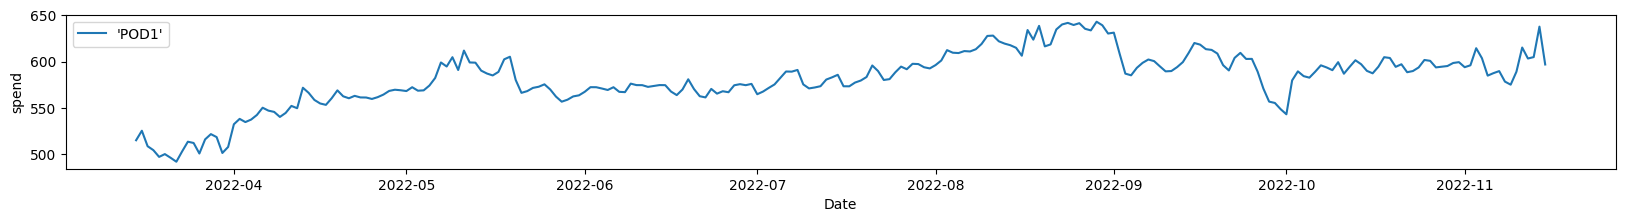

In [ ]:
showDF(train_df,'POD1',None)

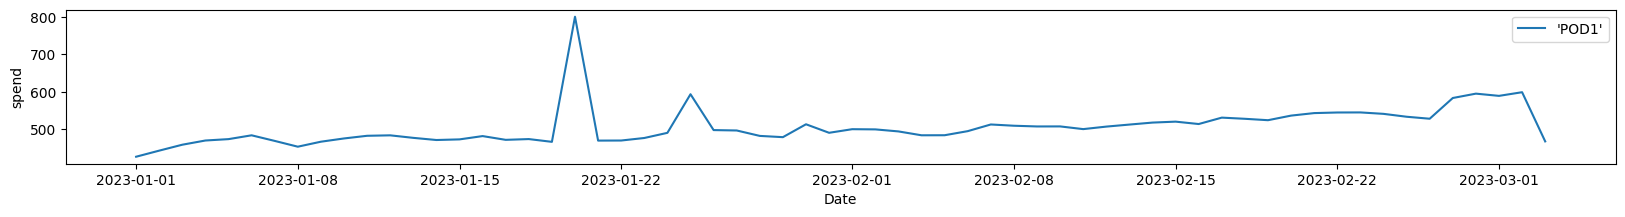

In [ ]:
showDF(test_df,'POD1',None)

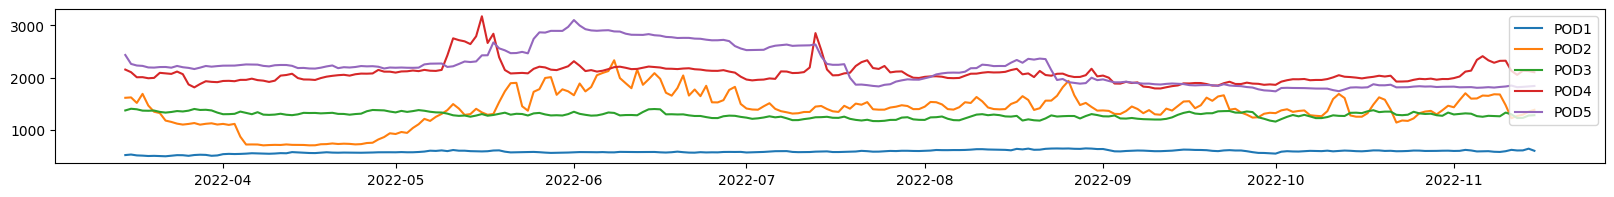

In [ ]:
plt.figure(1, figsize=(20, 2))
plt.plot(train_df)
plt.legend(train_df.columns)

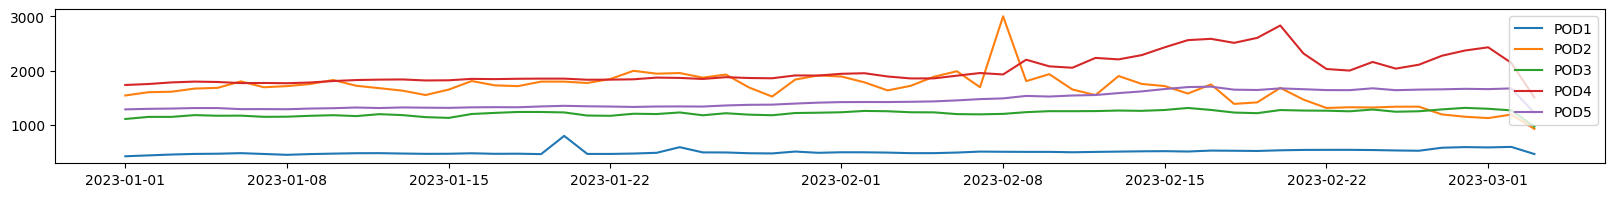

In [ ]:
plt.figure(1, figsize=(20, 2))
plt.plot(test_df)
plt.legend(test_df.columns)

In [ ]:
print(train_df.shape, test_df.shape)

(246, 5) (62, 5)


In [ ]:
print(train_df.index)

DatetimeIndex(['2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18',
               '2022-03-19', '2022-03-20', '2022-03-21', '2022-03-22',
               '2022-03-23', '2022-03-24',
               ...
               '2022-11-06', '2022-11-07', '2022-11-08', '2022-11-09',
               '2022-11-10', '2022-11-11', '2022-11-12', '2022-11-13',
               '2022-11-14', '2022-11-15'],
              dtype='datetime64[ns]', name='date', length=246, freq=None)


In [ ]:
scaler = StandardScaler()
train = scaler.fit_transform(train_df)
test = scaler.fit_transform(test_df)
print(train.shape, test.shape)

(246, 5) (62, 5)


In [ ]:
TIME_STEPS = 1

trainX = train.reshape(train.shape[0],TIME_STEPS,train.shape[1])
testX = test.reshape(test.shape[0],TIME_STEPS,test.shape[1])

print('trainX shape == {}.'.format(trainX.shape))
print('testX shape == {}.'.format(testX.shape))

trainX shape == (246, 1, 5).
testX shape == (62, 1, 5).


In [ ]:
dim1= trainX.shape[1]
dim2= trainX.shape[2]
print('TIME_STEPS=', dim1, 'Features', dim2 )
latent_dim =1

TIME_STEPS= 1 Features 5


In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
       z_mean, z_log_var = inputs
       batch = tf.shape(z_mean)[0]
       dim = tf.shape(z_mean)[1]
       epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
       return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
initializer = tf.keras.initializers.Zeros()

encoder_inputs = keras.Input(shape=(dim1, dim2), name='input')
encoder_output = layers.LSTM(units=64, return_sequences=False, name='EncoderLSTM')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder_output)
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer=initializer)(encoder_output)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 1, 5)]               0         []                            
                                                                                                  
 EncoderLSTM (LSTM)          (None, 64)                   17920     ['input[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 1)                    65        ['EncoderLSTM[0][0]']         
                                                                                                  
 z_log_var (Dense)           (None, 1)                    65        ['EncoderLSTM[0][0]']         
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
decoder_output = layers.RepeatVector(dim1)(latent_inputs)
decoder_output = layers.LSTM(units=64, return_sequences=True,name='DecoderLSTM')(decoder_output)
decoder_output = layers.Dropout(0.2)(decoder_output)
decoder_output = layers.TimeDistributed(layers.Dense(units=dim2))(decoder_output)
decoder = keras.Model(latent_inputs, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 1, 1)              0         
 tor)                                                            
                                                                 
 DecoderLSTM (LSTM)          (None, 1, 64)             16896     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 5)              325       
 stributed)                                                      
                                                                 
Total params: 17221 (67.27 KB)
Trainable params: 17221 (67.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        print("in init")
        self.encoder = encoder
        self.decoder = decoder
        print("set encoder and decoder")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.accuracy = tf.keras.metrics.Accuracy()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            #self.accuracy,

        ]

    def train_step(self, data):

        input, hat = data
        with tf.GradientTape() as tape:
            # pull out x from data, feed into encoder and decoder
            z_mean, z_log_var, z = self.encoder(input)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(hat, reconstruction), axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + .01*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        input, hat = data
        z_mean, z_log_var, z = self.encoder(input)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(hat, reconstruction), axis=(1)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + 0.01*kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction

In [ ]:
model = VAE(encoder, decoder)
model.compile(optimizer=keras.optimizers.Adam())

in init
set encoder and decoder


Learning rate per epoch:


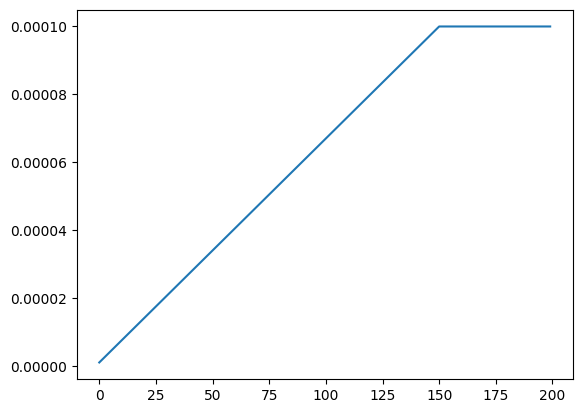

In [ ]:
import math
EPOCHS = 200

start_lr = 0.000001
min_lr = 0.00000001
max_lr = 0.0001
rampup_epochs = 150
sustain_epochs = 50
k = 0.6
exp_decay = start_lr * math.exp(-k*EPOCHS)

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:
# es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience = 7)
history=model.fit(trainX, trainX, epochs=EPOCHS, batch_size=16,  callbacks = [lr_callback], verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/200
16/16 [==============================] - 5s 9ms/step - loss: 1.0787 - reconstruction_loss: 0.9906 - kl_loss: 0.0013 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.66e-06.
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.9729 - reconstruction_loss: 0.9962 - kl_loss: 0.0013 - lr: 1.6600e-06

Epoch 3: LearningRateScheduler setting learning rate to 2.32e-06.
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.9854 - reconstruction_loss: 1.0031 - kl_loss: 0.0013 - lr: 2.3200e-06

Epoch 4: LearningRateScheduler setting learning rate to 2.9800000000000003e-06.
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 1.0204 - reconstruction_loss: 1.0014 - kl_loss: 0.0013 - lr: 2.9800e-06

Epoch 5: LearningRateScheduler setting learning rate to 3.64e-06.
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0

In [ ]:
model.save(modelpath+'Cost_Anomaly_Multi_LSTM_VAE_Final.model')

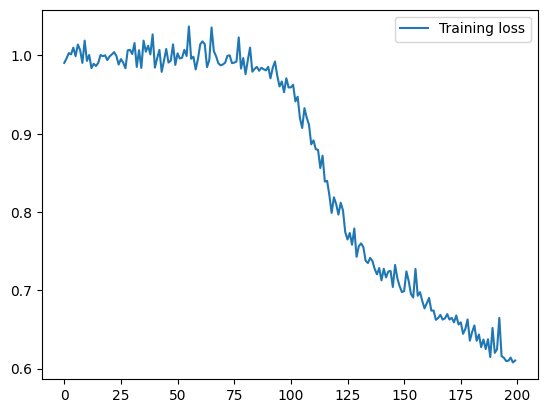

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [ ]:
pred_train = model.predict(trainX)
train_mae_loss = np.mean(np.abs(pred_train - trainX), axis=1)

8/8 [==============================] - 1s 4ms/step


<ipython-input-83-799f7bf2afcd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


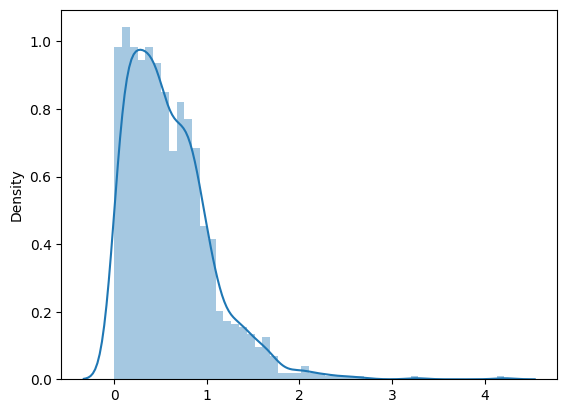

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
pred_test = model.predict(testX)

test_mae_loss = np.mean(np.abs(pred_test - testX), axis=1)

2/2 [==============================] - 0s 7ms/step


<ipython-input-85-31ca0369e6a8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_mae_loss, bins=50, kde=True);


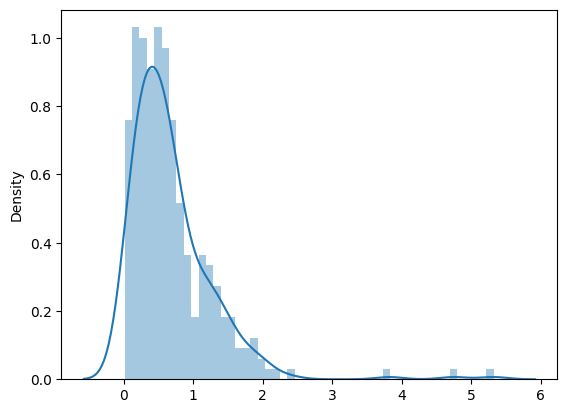

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True);

In [ ]:
THRESHOLD = np.mean(train_mae_loss) + np.std(train_mae_loss)
print(THRESHOLD)

1.0490581680327113


In [ ]:
def prepareAnomaly(mdf,name,l,threshold):
  test_score_df = pd.DataFrame(index=mdf.index)
  test_score_df['loss'] = l
  test_score_df['threshold'] = threshold
  test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
  test_score_df[name] = mdf[name]
  anomalies = test_score_df[test_score_df.anomaly == True]
  anomalies.head()
  return test_score_df ,anomalies

In [ ]:
def showLossThreshold(df):
  plt.plot(df.index, df.loss, label='loss')
  plt.plot(df.index, df.threshold, label='threshold')
  plt.xticks(rotation=25)
  plt.legend();

In [ ]:
def getloss(df):
  X_pred = model.predict(df)
  X_pred = X_pred.reshape(X_pred.shape[0],X_pred.shape[2])
  Xtest = testX.reshape(testX.shape[0],testX.shape[2])
  test_mae_loss = np.mean(np.abs(X_pred - Xtest), axis=1)
  return test_mae_loss


2/2 [==============================] - 0s 7ms/step


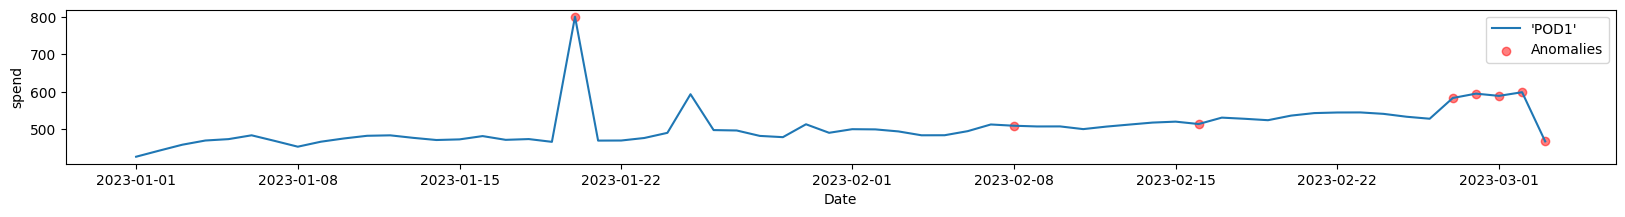

In [ ]:
test_mae_loss = getloss(testX)
ldf,anomalies = prepareAnomaly(test_df,'POD1',test_mae_loss,THRESHOLD)
showDF(test_df,'POD1',anomalies)

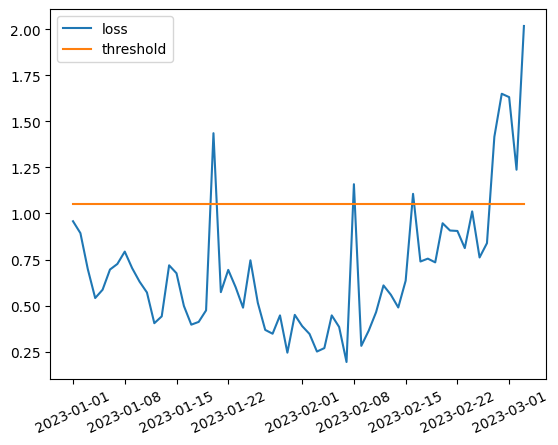

In [ ]:
showLossThreshold(ldf)

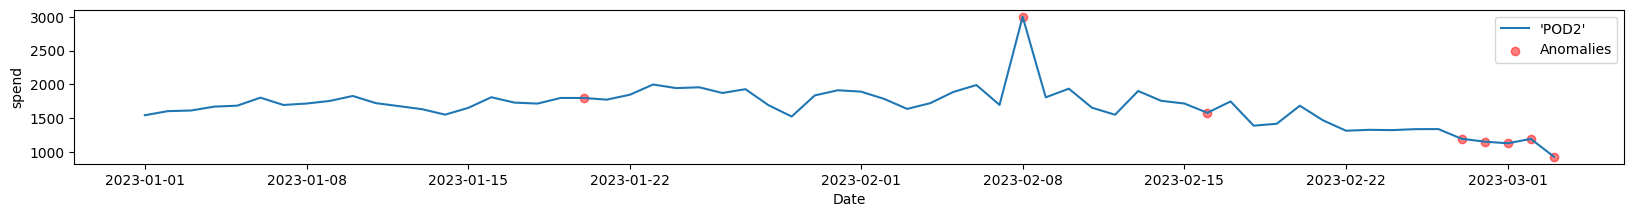

In [ ]:
# test_mae_loss = getloss(testX)
ldf,anomalies = prepareAnomaly(test_df,'POD2',test_mae_loss,THRESHOLD)
showDF(test_df,'POD2',anomalies)

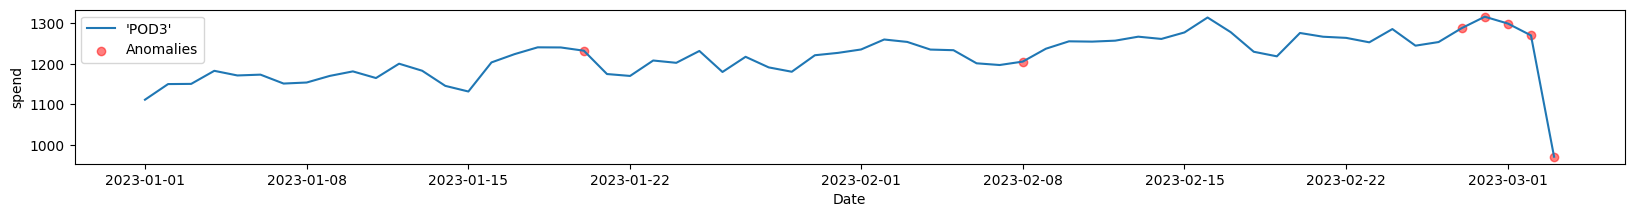

In [ ]:
ldf,anomalies = prepareAnomaly(test_df,'POD3',test_mae_loss,THRESHOLD)
showDF(test_df,'POD3',anomalies)

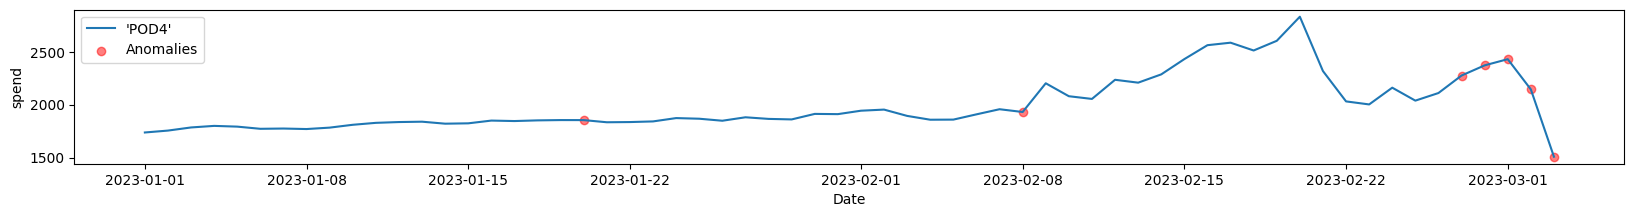

In [ ]:
ldf,anomalies = prepareAnomaly(test_df,'POD4',test_mae_loss,THRESHOLD)
showDF(test_df,'POD4',anomalies)

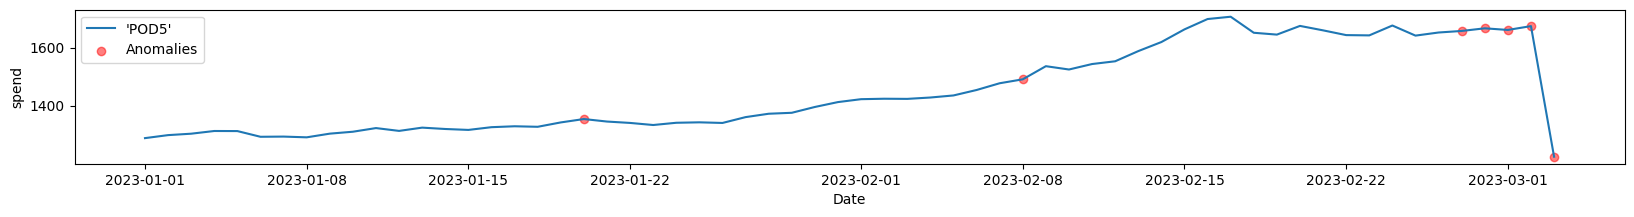

In [ ]:
ldf,anomalies = prepareAnomaly(test_df,'POD5',test_mae_loss,THRESHOLD)
showDF(test_df,'POD5',anomalies)